# Proyek Akhir : Image Classification Model Deployment
- Nama: Jeremy Ethan Novriawan
- Id Dicoding: jeremyethann

Data dari https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

# Library

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import shutil
import tensorflow as tf

!pip install kaggle
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Flatten, MaxPooling2D, RandomFlip, RandomRotation, Dropout, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Dataset

In [ ]:
# Upload kunci Kaggle API (kaggle.json)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Membuat direktori
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download direktori dari kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 99% 217M/219M [00:11<00:00, 21.7MB/s]
100% 219M/219M [00:11<00:00, 20.1MB/s]


In [ ]:
# Unzip dataset
!unzip -q rice-image-dataset.zip

# Mengeksplorasi dataset

In [ ]:
# Mendefinisikan path
combined_set_path = '/content/Rice_Image_Dataset'

Jasmine: 15000 images


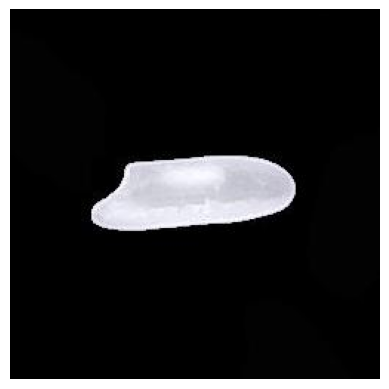

Ipsala: 15000 images


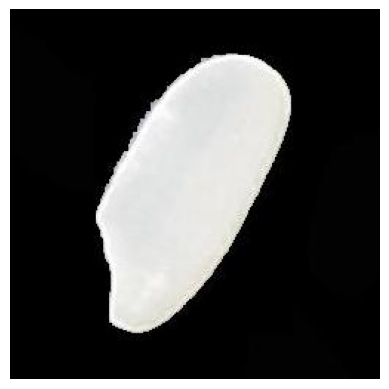

Basmati: 15000 images


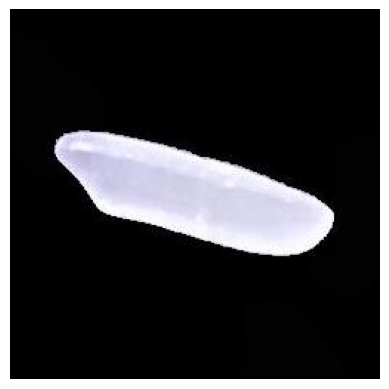

Arborio: 15000 images


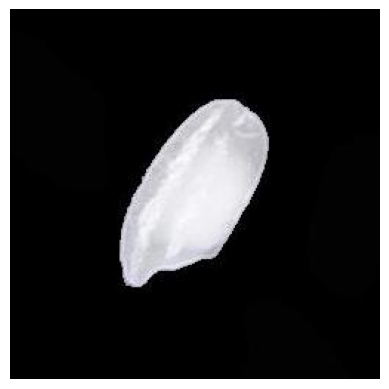

Karacadag: 15000 images


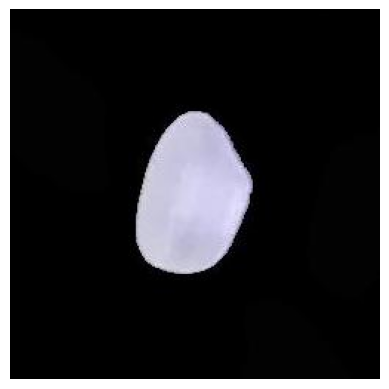

Total number of images: 75000


In [ ]:
# Mendefinisikan kelas-kelas
class_dirs = ['Jasmine','Ipsala','Basmati','Arborio','Karacadag']

# Variabel untuk menghitung jumlah gambar
total_images = 0

def load_and_display_random_image(image_dir):
    random_image = random.choice(os.listdir(image_dir))
    img_path = os.path.join(image_dir, random_image)
    img = image.load_img(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Iterasi untuk direktori masing-masing kelas
for class_dir in class_dirs:
    # Mendefinisikan path untuk masing-masing kelas
    current_dir = os.path.join(combined_set_path, class_dir)

    # Menghitung jumlah gambar setiap kelasnya
    num_images = len(os.listdir(current_dir))
    total_images += num_images

    # Mengeluarkan jumlah gambar setiap kelasnya
    print(f"{class_dir}: {num_images} images")

    # Menampilkan gambar secara acak untuk setiap kelasnya
    load_and_display_random_image(current_dir)

# Menampilkan jumlah gambar yang dikelola
print("Total number of images:", total_images)

Total sampel/gambar ada 75000, lebih dari 10000 sampel

# Praproses

## Image Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    fill_mode = 'nearest',
                    brightness_range=[0.3, 0.9],
                    validation_split=0.2)

validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        combined_set_path,
        target_size=(50, 50),  # mengubah resolusi seluruh gambar menjadi 50x50 piksel
        batch_size=32,
        # karena ini merupakan masalah klasifikasi 5 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical',
        subset='training',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        combined_set_path,
        target_size=(50, 50), # mengubah resolusi seluruh gambar menjadi 50x50 piksel
        batch_size=32,
        # karena ini merupakan masalah klasifikasi 5 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical',
        subset='validation',
        seed=42)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


Dapat diperhatikan dataset dibagi menjadi 80% training dan 20% validasi

# Model

In [ ]:
# Pembuatan model dengan Sequential, Conv2D Maxpooling layer, dan dropout
model = Sequential([
    Input(shape=(50, 50, 3)),
    # CNN layer pertama
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(2,2),

    # CNN layer kedua
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(class_dirs), activation='softmax')
])

# Menentukan optimizer, loss, dan metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# Jumlah epochs
num_epochs = 50

# Kriteria pemberhentian awal dengan memperhatikan val_accuracy dengan kesabaran 15
early_stopping = EarlyStopping(monitor="val_accuracy",
                              mode="max", patience=15,
                              restore_best_weights=True)

# Callback untuk mencegah overfitting dengan menghentikan training jika akurasi di atas 0.92
class StopTrainingIfAccuracyAbove(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.92 and logs['val_accuracy'] > 0.92:
            print("\nStopped! Training accuracy and validation accuracy both above 92%.")
            self.model.stop_training = True

stop = StopTrainingIfAccuracyAbove()

# Menyimpan pada history untuk plotting loss dan mae pada training dan validasi
history = model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[early_stopping, stop], verbose=2)

Epoch 1/50
1875/1875 - 145s - loss: 0.8026 - accuracy: 0.6744 - val_loss: 0.8386 - val_accuracy: 0.6816 - 145s/epoch - 77ms/step
Epoch 2/50
1875/1875 - 130s - loss: 0.4409 - accuracy: 0.8394 - val_loss: 0.6958 - val_accuracy: 0.7592 - 130s/epoch - 69ms/step
Epoch 3/50
1875/1875 - 144s - loss: 0.3257 - accuracy: 0.8850 - val_loss: 0.5667 - val_accuracy: 0.7903 - 144s/epoch - 77ms/step
Epoch 4/50
1875/1875 - 135s - loss: 0.2614 - accuracy: 0.9072 - val_loss: 0.5778 - val_accuracy: 0.7939 - 135s/epoch - 72ms/step
Epoch 5/50
1875/1875 - 139s - loss: 0.2286 - accuracy: 0.9198 - val_loss: 0.2773 - val_accuracy: 0.8912 - 139s/epoch - 74ms/step
Epoch 6/50
1875/1875 - 131s - loss: 0.2058 - accuracy: 0.9277 - val_loss: 0.4577 - val_accuracy: 0.8361 - 131s/epoch - 70ms/step
Epoch 7/50
1875/1875 - 140s - loss: 0.1870 - accuracy: 0.9355 - val_loss: 0.2927 - val_accuracy: 0.8899 - 140s/epoch - 75ms/step
Epoch 8/50
1875/1875 - 133s - loss: 0.1737 - accuracy: 0.9401 - val_loss: 0.2198 - val_accuracy: 

### Cek jika acc dan val_acc lebih besar daripada threshold acc

In [ ]:
threshold_acc=0.92

In [ ]:
threshold_acc<=history.history['val_accuracy'][-1]

True

In [ ]:
threshold_acc<=history.history['accuracy'][-1]

True

# Plot accuracy dan loss tiap epoch

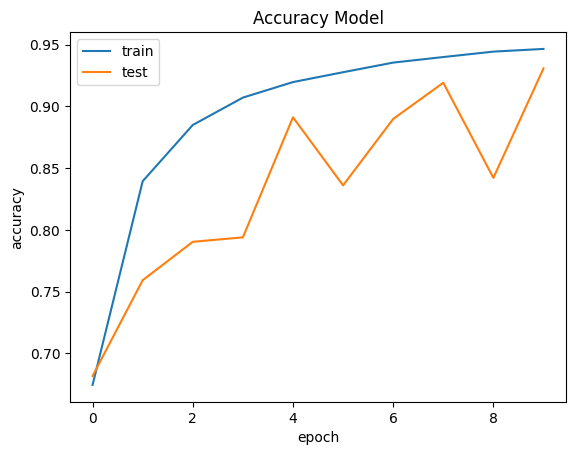

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

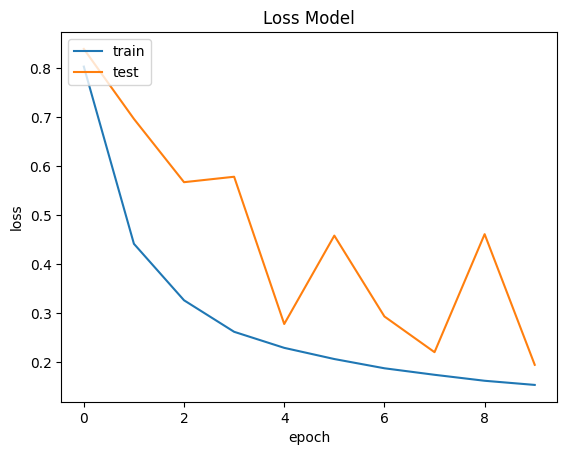

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Deployment

In [ ]:
# Konversi ke tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# simpan
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)